In [ ]:
!pip install gdown
!pip install tensorflow_hub

import os
import zipfile
import gdown
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
import os

# Atur random seed untuk hasil yang bisa direproduksi
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio

def extract_embeddings(audio):
    _, embeddings, _ = yamnet_model(audio)
    return embeddings.numpy()


In [ ]:
dataset_url = "https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5"
dataset_zip = "ravdess.zip"
gdown.download(dataset_url, dataset_zip, quiet=False)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

DATASET_PATH = "ravdess_data"

Downloading...
From (original): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5
From (redirected): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5&confirm=t&uuid=fd018768-2d63-4e9a-a6a1-cfd8f1570a37
To: /content/ravdess.zip
100%|██████████| 450M/450M [00:09<00:00, 45.0MB/s]


In [ ]:
import pandas as pd

In [ ]:
file_paths = []
labels = []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            file_paths.append(path)

            # Label emosi diambil dari penamaan file RAVDESS
            parts = file.split("-")
            emotion_id = int(parts[2])  # indeks ke-3 menunjukkan emosi (contoh: 03 untuk happy)
            labels.append(emotion_id)

# Buat DataFrame
df = pd.DataFrame({
    "filepath": file_paths,
    "emotion_id": labels
})

# Lihat 5 baris pertama
df.head()

,filepath,emotion_id
0,ravdess_data/Actor_19/03-01-08-01-01-02-19.wav,8
1,ravdess_data/Actor_19/03-01-03-01-02-01-19.wav,3
2,ravdess_data/Actor_19/03-01-08-02-02-01-19.wav,8
3,ravdess_data/Actor_19/03-01-03-02-02-01-19.wav,3
4,ravdess_data/Actor_19/03-01-06-01-02-01-19.wav,6


In [ ]:
def augment_audio(audio, sr):
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)
    audio_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    noise = np.random.normal(0, 0.01, len(audio))
    audio_noisy = audio + noise
    return [audio_stretched, audio_shifted, audio_noisy]

X, y = [], []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            audio = preprocess_audio(file_path)
            embedding_seq = extract_embeddings(audio)

            label = file.split('-')[2]
            X.append(embedding_seq)
            y.append(label)

            augmented_audios = augment_audio(audio, sr=16000)
            for aug_audio in augmented_audios:
                aug_embedding_seq = extract_embeddings(aug_audio)
                X.append(aug_embedding_seq)
                y.append(label)

print(f"Total data after augmentation: {len(X)} samples")

X_padded = pad_sequences(X, padding='post', dtype='float32')
print("Shape after padding:", X_padded.shape)

num_samples, max_len, emb_dim = X_padded.shape
X_reshaped = X_padded.reshape(-1, emb_dim)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, max_len, emb_dim)


Total data after augmentation: 11520 samples
Shape after padding: (11520, 10, 1024)


In [ ]:
def label_to_multilabel(label):
    mapping = {
        '01': ['neutral'],
        '02': ['calm'],
        '03': ['happy'],
        '04': ['sad'],
        '05': ['angry'],
        '06': ['fearful'],
        '07': ['disgust'],
        '08': ['surprised']
    }
    return mapping.get(label, [])

multi_labels = [label_to_multilabel(lab) for lab in y]

mlb = MultiLabelBinarizer()
y_multi_encoded = mlb.fit_transform(multi_labels)

print("Example Multi-Label Encoding:", y_multi_encoded[0])
print("Emotion Classes:", mlb.classes_)

Example Multi-Label Encoding: [0 0 0 0 0 0 0 1]
Emotion Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
# DataFrame awal (misalnya y masih label original)
df_labels = pd.DataFrame({'Original_Label': y})

# Multi-label hasil encoding
df_encoded = pd.DataFrame(y_multi_encoded, columns=mlb.classes_)

# Gabung untuk melihat perubahan
df_check = pd.concat([df_labels, df_encoded], axis=1)

print(df_check.head(10))

  Original_Label  angry  calm  disgust  fearful  happy  neutral  sad  \
0             08      0     0        0        0      0        0    0   
1             08      0     0        0        0      0        0    0   
2             08      0     0        0        0      0        0    0   
3             08      0     0        0        0      0        0    0   
4             03      0     0        0        0      1        0    0   
5             03      0     0        0        0      1        0    0   
6             03      0     0        0        0      1        0    0   
7             03      0     0        0        0      1        0    0   
8             08      0     0        0        0      0        0    0   
9             08      0     0        0        0      0        0    0   

   surprised  
0          1  
1          1  
2          1  
3          1  
4          0  
5          0  
6          0  
7          0  
8          1  
9          1  


In [ ]:
# 1. Masking function + Filter valid sequences
def mask_embeddings(X, mask_rate=0.1):
    X_masked = np.copy(X)
    for i in range(X.shape[0]):
        num_mask = int(X.shape[1] * mask_rate)
        mask_indices = np.random.choice(X.shape[1], num_mask, replace=False)
        X_masked[i, mask_indices, :] = 0

    # Setelah masking, filter out sequences yang kosong total
    valid_indices = np.where(np.sum(np.any(X_masked != 0, axis=-1), axis=1) > 0)[0]
    X_masked = X_masked[valid_indices]
    X_target = X[valid_indices]  # target harus sama valid

    return X_masked, X_target

# 2. Apply masking + filter
X_ssl_input, X_ssl_target = mask_embeddings(X_scaled)

print("Final shape for SSL input:", X_ssl_input.shape)
print("Final shape for SSL target:", X_ssl_target.shape)




Final shape for SSL input: (11520, 10, 1024)
Final shape for SSL target: (11520, 10, 1024)


In [ ]:
# 3. Build SSL model
def build_ssl_model(max_len, emb_dim):
    inputs = tf.keras.Input(shape=(max_len, emb_dim))
    x = tf.keras.layers.Masking(mask_value=0.)(inputs)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64), return_sequences=True)(x)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)(x)
    x = tf.keras.layers.Dense(emb_dim)(x)
    model = tf.keras.Model(inputs, x)
    return model


ssl_model = build_ssl_model(max_len, emb_dim)
ssl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mae')
ssl_model_history = ssl_model.fit(X_ssl_input, X_ssl_target,
                                  epochs=50,
                                  batch_size=32,
                                  validation_split=0.2,
                                  callbacks=[
                                      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                                       ])

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.4174 - val_loss: 0.2581
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.2134 - val_loss: 0.1640
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.1599 - val_loss: 0.1551
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.1513 - val_loss: 0.1458
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1435 - val_loss: 0.1372
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1358 - val_loss: 0.1289
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.1280 - val_loss: 0.1238
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.1230 - val_loss: 0.1206
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.1198 - val_loss: 0.1182
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.1177 - val_loss: 0.1169
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.1165 - val_loss: 0.1149
Epoch 12/50
288/288 ━━━━━━━━━━━━━━

Menampilkan perbandingan untuk 5 sampel pertama...



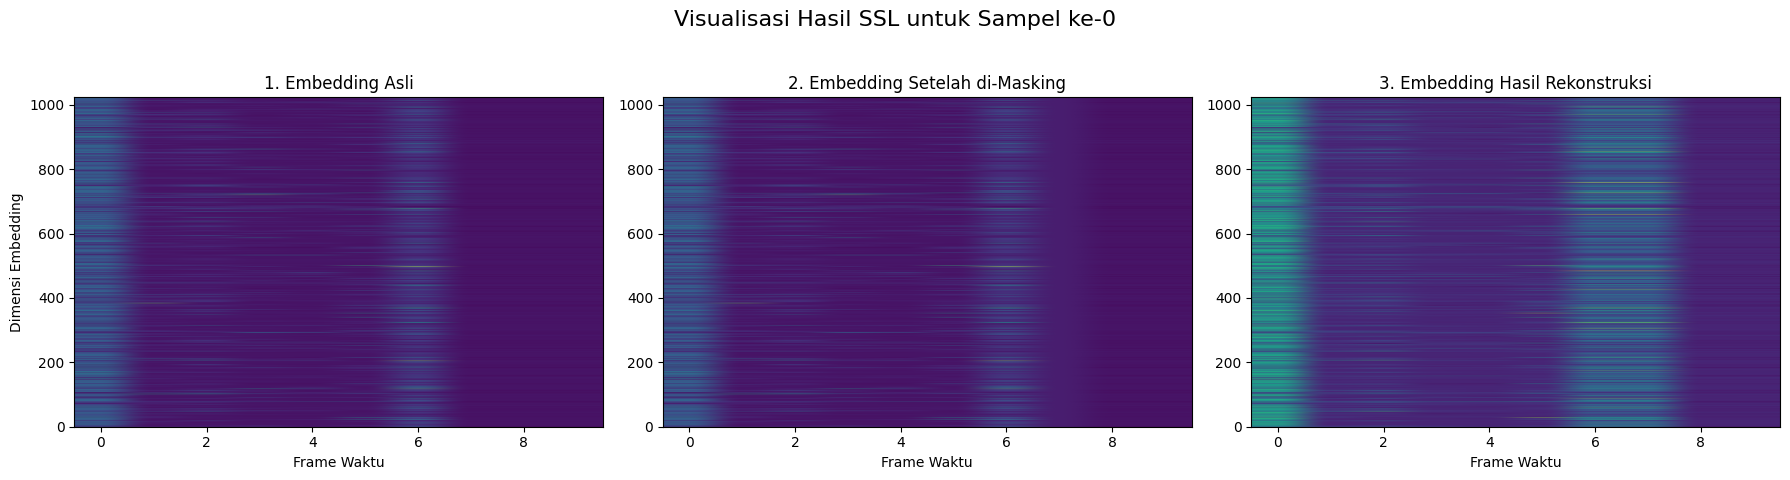

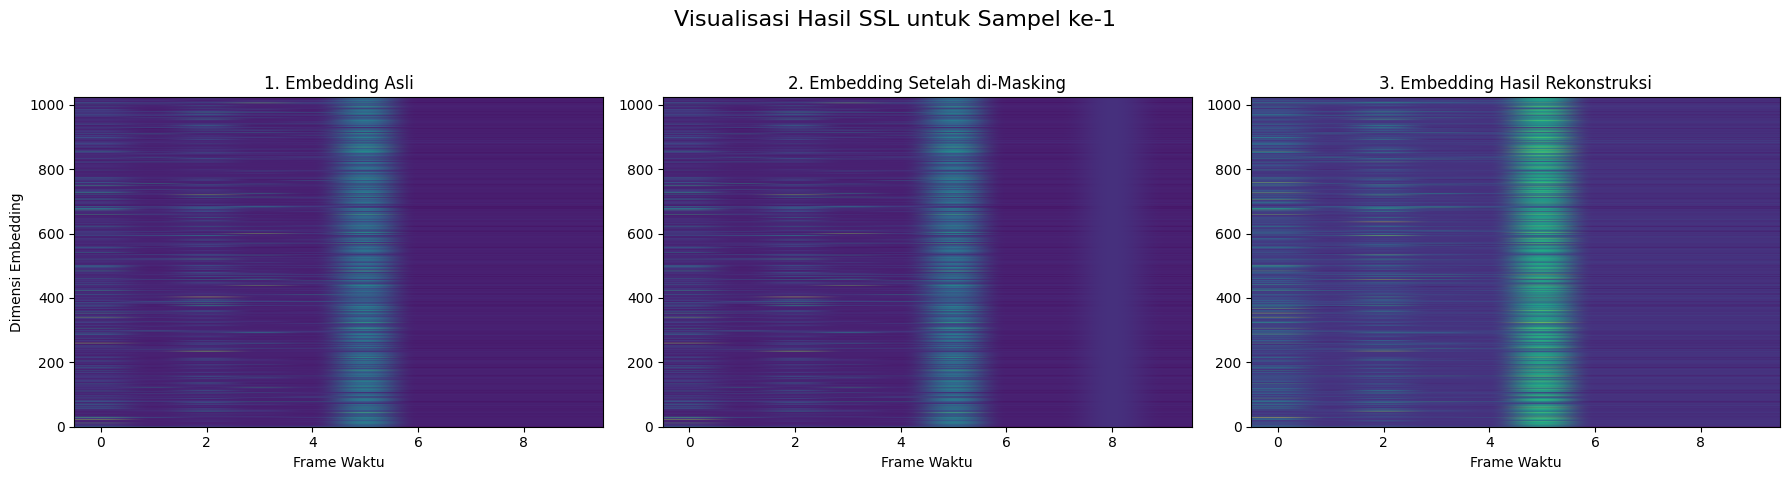

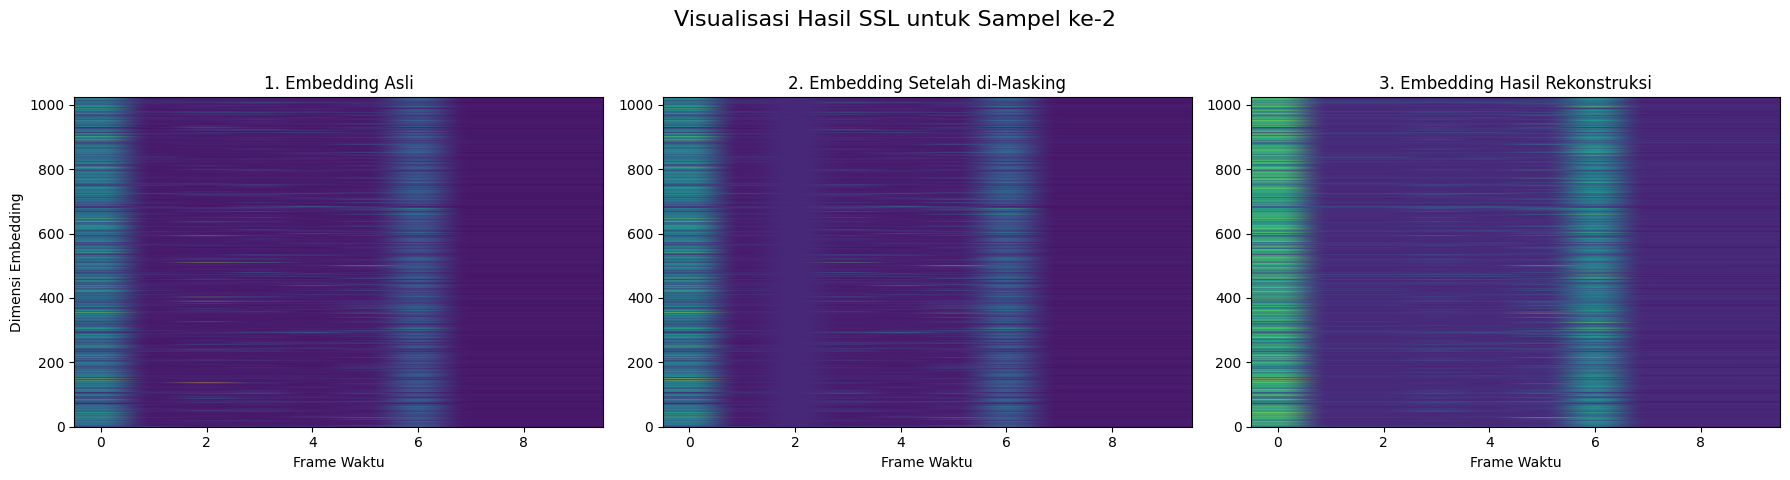

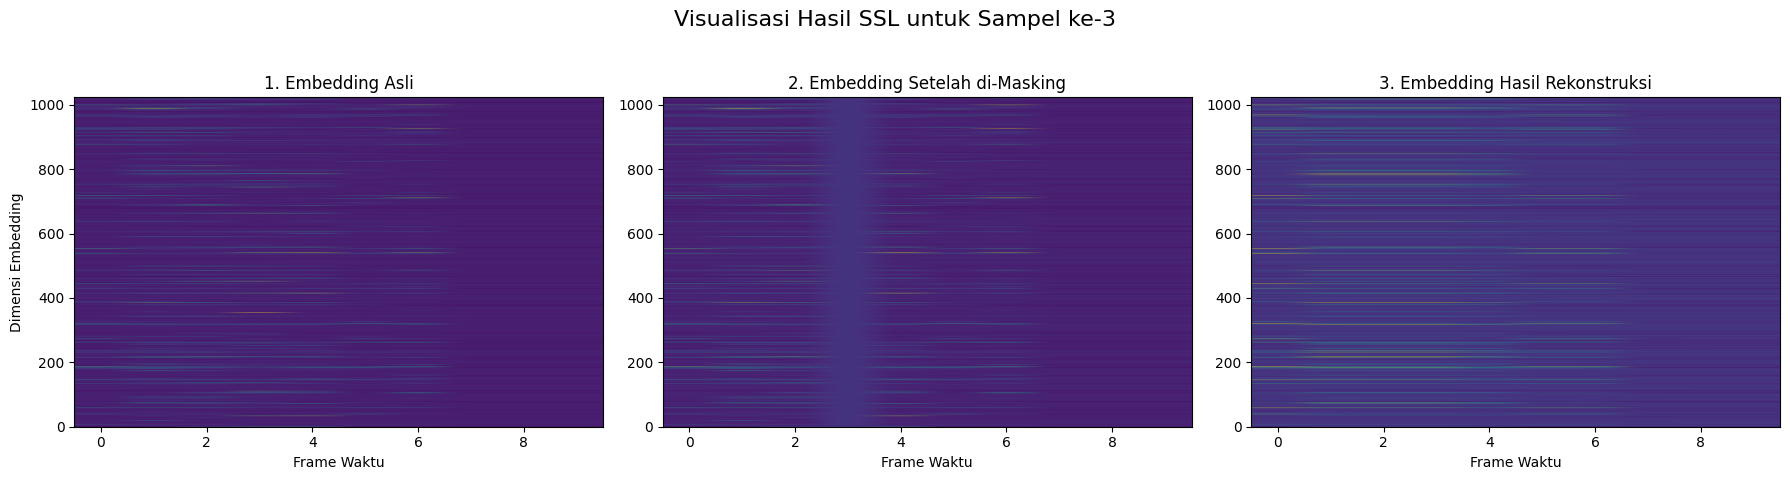

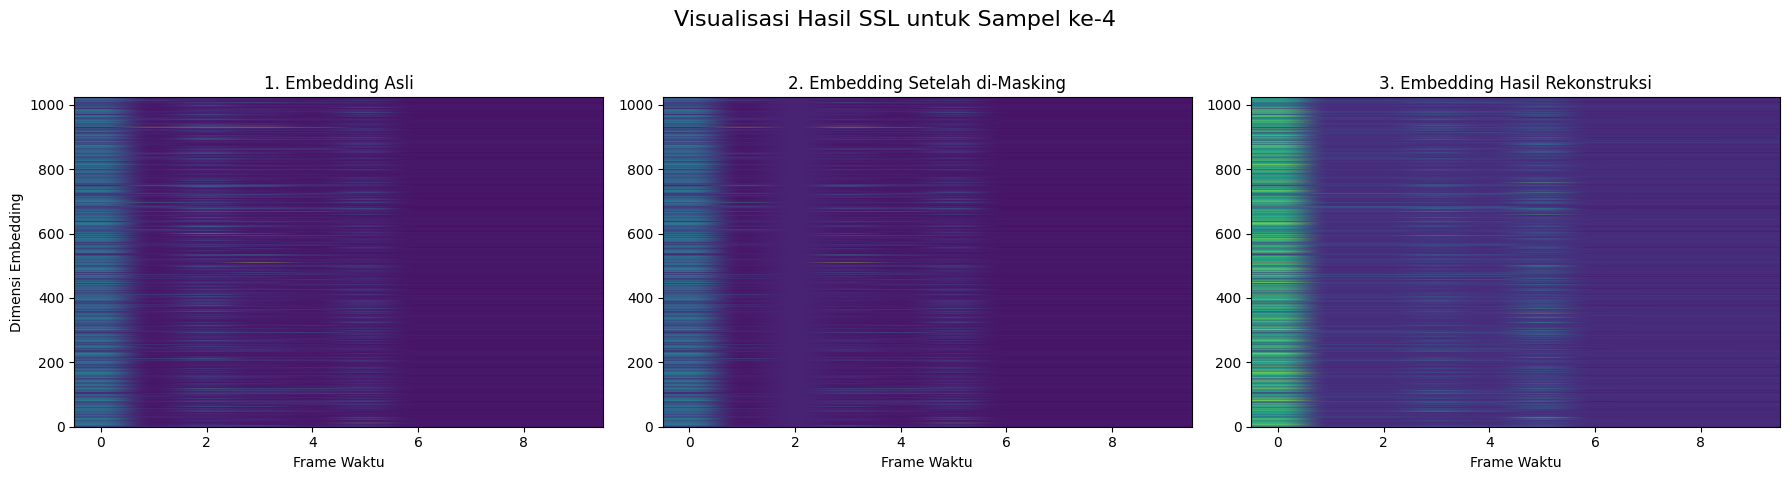

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Jumlah sampel yang ingin ditampilkan (Anda bisa ubah angka ini, misal 3 atau 5)
jumlah_sampel_untuk_ditampilkan = 5

print(f"Menampilkan perbandingan untuk {jumlah_sampel_untuk_ditampilkan} sampel pertama...\n")

# Loop sebanyak sampel yang diinginkan
for i in range(jumlah_sampel_untuk_ditampilkan):
    sample_index = i
    original_embedding = X_ssl_target[sample_index]
    masked_embedding = X_ssl_input[sample_index]

    # Prediksi dengan model SSL (verbose=0 agar output tidak ramai)
    masked_embedding_batch = np.expand_dims(masked_embedding, axis=0)
    reconstructed_embedding = ssl_model.predict(masked_embedding_batch, verbose=0)[0]

    # --- Visualisasi Hasil ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Plot Asli
    axes[0].imshow(original_embedding.T, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title("1. Embedding Asli")
    axes[0].set_xlabel("Frame Waktu")
    axes[0].set_ylabel("Dimensi Embedding")

    # 2. Plot Masked
    axes[1].imshow(masked_embedding.T, aspect='auto', origin='lower', cmap='viridis')
    axes[1].set_title("2. Embedding Setelah di-Masking")
    axes[1].set_xlabel("Frame Waktu")

    # 3. Plot Rekonstruksi
    axes[2].imshow(reconstructed_embedding.T, aspect='auto', origin='lower', cmap='viridis')
    axes[2].set_title("3. Embedding Hasil Rekonstruksi")
    axes[2].set_xlabel("Frame Waktu")

    plt.suptitle(f"Visualisasi Hasil SSL untuk Sampel ke-{sample_index}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Tampilkan plot untuk sampel ini

In [ ]:
import pandas as pd
import numpy as np

# Mengatur agar pandas menampilkan semua baris (untuk 10 frame waktu)
pd.set_option('display.max_rows', 20)

# Pastikan variabel-variabel ini sudah ada dari sel-sel sebelumnya:
# X_ssl_target, X_ssl_input, ssl_model

# Ambil satu sampel data untuk perbandingan (misalnya, sampel ke-2)
sample_index = 2
original_embedding = X_ssl_target[sample_index]
masked_embedding = X_ssl_input[sample_index]

# Minta model SSL untuk merekonstruksi embedding
masked_embedding_batch = np.expand_dims(masked_embedding, axis=0)
reconstructed_embedding = ssl_model.predict(masked_embedding_batch, verbose=0)[0]

# --- Ubah menjadi DataFrame ---
# Membuat nama kolom agar mudah dibaca (Fitur_0, Fitur_1, dst.)
column_names = [f"Fitur_{i}" for i in range(original_embedding.shape[1])]

df_original = pd.DataFrame(original_embedding, columns=column_names)
df_masked = pd.DataFrame(masked_embedding, columns=column_names)
df_reconstructed = pd.DataFrame(reconstructed_embedding, columns=column_names)

# --- Tampilkan Hasil ---
print("--- 1. Tabel Embedding Asli (5 Kolom Pertama) ---")
display(df_original.iloc[:, :5])

print("\n--- 2. Tabel Embedding Setelah di-Masking (5 Kolom Pertama) ---")
print("Perhatikan baris yang nilainya menjadi 0 semua. Itulah frame yang di-masking.")
display(df_masked.iloc[:, :5])

print("\n--- 3. Tabel Embedding Hasil Rekonstruksi (5 Kolom Pertama) ---")
print("Nilai pada baris yang sebelumnya 0 kini telah diisi kembali oleh model.")
display(df_reconstructed.iloc[:, :5])

--- 1. Tabel Embedding Asli (5 Kolom Pertama) ---


,Fitur_0,Fitur_1,Fitur_2,Fitur_3,Fitur_4
0,2.507933,0.915122,0.078156,0.457959,1.965213
1,-0.251594,2.049770,-0.220364,-0.390284,-0.371004
2,0.067358,-0.607439,-0.171809,-0.050971,-0.371004
3,-0.393153,-0.663406,2.883781,-0.390284,-0.371004
4,-0.410571,0.170607,1.018129,-0.077246,-0.371004
5,-0.421504,-0.375625,-0.540156,4.689724,-0.371004
6,2.272709,0.346417,0.750641,4.058472,1.082490
7,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004
8,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004
9,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004



--- 2. Tabel Embedding Setelah di-Masking (5 Kolom Pertama) ---
Perhatikan baris yang nilainya menjadi 0 semua. Itulah frame yang di-masking.


,Fitur_0,Fitur_1,Fitur_2,Fitur_3,Fitur_4
0,2.507933,0.915122,0.078156,0.457959,1.965213
1,-0.251594,2.049770,-0.220364,-0.390284,-0.371004
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.393153,-0.663406,2.883781,-0.390284,-0.371004
4,-0.410571,0.170607,1.018129,-0.077246,-0.371004
5,-0.421504,-0.375625,-0.540156,4.689724,-0.371004
6,2.272709,0.346417,0.750641,4.058472,1.082490
7,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004
8,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004
9,-0.421504,-0.663406,-0.540156,-0.390284,-0.371004



--- 3. Tabel Embedding Hasil Rekonstruksi (5 Kolom Pertama) ---
Nilai pada baris yang sebelumnya 0 kini telah diisi kembali oleh model.


,Fitur_0,Fitur_1,Fitur_2,Fitur_3,Fitur_4
0,2.796217,0.246385,1.921520,1.148335,2.335719
1,-0.355895,0.668171,-0.285941,-0.315686,-0.371722
2,-0.355895,0.668171,-0.285941,-0.315686,-0.371722
3,-0.245076,-0.672291,0.734656,0.127501,-0.372238
4,-0.394464,0.136740,-0.219319,-0.319357,-0.374905
5,-0.310697,-0.018369,-0.403026,0.619631,-0.383923
6,2.082878,0.300415,0.477157,1.460373,1.375065
7,-0.421480,-0.667172,-0.540359,-0.387938,-0.371921
8,-0.422596,-0.660085,-0.541820,-0.388700,-0.372468
9,-0.422584,-0.661230,-0.540499,-0.388869,-0.372510


In [ ]:
n_splits = 10
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_histories = []
fold_scores = []
fold_predictions = []
fold_true_labels = []

In [ ]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(X_scaled)):
    print(f"======================================================")
    print(f"=============== FOLD {fold + 1}/{n_splits} =================")
    print(f"======================================================")

    # Pembagian data untuk fold saat ini berdasarkan indeks
    X_train, X_val = X_scaled[train_ids], X_scaled[val_ids]
    y_train, y_val = y_multi_encoded[train_ids], y_multi_encoded[val_ids]

    # --- 3. Buat Ulang Model di Setiap Iterasi (SANGAT PENTING) ---
    # Ini memastikan setiap fold dievaluasi dengan model yang "fresh"
    print("Membangun ulang arsitektur model...")

    # Pre-trained SSL model (jika Anda melatihnya, muat ulang bobotnya di sini jika perlu)
    ssl_model_fold = build_ssl_model(max_len=X_train.shape[1], emb_dim=X_train.shape[2])

    # Model fine-tuning
    fine_tune_model_fold = tf.keras.Sequential([
        ssl_model_fold,
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid') # y_train.shape[1] adalah jumlah kelas
    ])

    # Kompilasi model
    fine_tune_model_fold.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Definisikan callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    print(f"Memulai pelatihan untuk fold {fold + 1}...")
    # --- 4. Latih Model ---
    history = fine_tune_model_fold.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=2 # Menggunakan verbose=2 agar log tidak terlalu panjang
    )
    # --- 5. Evaluasi dan Simpan Hasil dari Fold Ini ---
    print(f"Mengevaluasi model pada data validasi fold {fold + 1}...")
    scores = fine_tune_model_fold.evaluate(X_val, y_val, verbose=0)

    fold_scores.append(scores)
    fold_histories.append(history)

    # Simpan prediksi untuk analisis confusion matrix agregat nanti
    y_pred = fine_tune_model_fold.predict(X_val)
    fold_predictions.append(y_pred)
    fold_true_labels.append(y_val)

    print(f"Skor untuk Fold {fold + 1}: Loss={scores[0]:.4f}, Accuracy={scores[1]*100:.2f}%")

=============== FOLD 1/10 =================
Membangun ulang arsitektur model...
Memulai pelatihan untuk fold 1...
Epoch 1/100
324/324 - 14s - 43ms/step - accuracy: 0.1833 - loss: 0.4154 - val_accuracy: 0.3490 - val_loss: 0.3342 - learning_rate: 5.0000e-04
Epoch 2/100
324/324 - 20s - 60ms/step - accuracy: 0.2992 - loss: 0.3550 - val_accuracy: 0.4479 - val_loss: 0.2934 - learning_rate: 5.0000e-04
Epoch 3/100
324/324 - 10s - 29ms/step - accuracy: 0.3877 - loss: 0.3226 - val_accuracy: 0.4922 - val_loss: 0.2669 - learning_rate: 5.0000e-04
Epoch 4/100
324/324 - 10s - 32ms/step - accuracy: 0.4391 - loss: 0.2994 - val_accuracy: 0.5234 - val_loss: 0.2571 - learning_rate: 5.0000e-04
Epoch 5/100
324/324 - 11s - 33ms/step - accuracy: 0.4922 - loss: 0.2788 - val_accuracy: 0.5469 - val_loss: 0.2410 - learning_rate: 5.0000e-04
Epoch 6/100
324/324 - 9s - 29ms/step - accuracy: 0.5407 - loss: 0.2563 - val_accuracy: 0.5790 - val_loss: 0.2283 - learning_rate: 5.0000e-04
Epoch 7/100
324/324 - 10s - 32ms/st

In [ ]:
# --- 6. Analisis Hasil Akhir Setelah Semua Fold Selesai ---
print("\n======================================================")
print("=============== ANALISIS HASIL AKHIR K-FOLD ===============")
print("======================================================")

# Mengambil skor akurasi dari setiap fold
accuracy_scores = [score[1] for score in fold_scores]

# Menghitung rata-rata dan standar deviasi
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Hasil Evaluasi dari {n_splits}-Fold Cross-Validation:")
print(f"  - Rata-rata Akurasi Validasi: {mean_accuracy * 100:.2f}%")
print(f"  - Standar Deviasi Akurasi: {std_accuracy * 100:.2f}%")


mean_loss = np.mean([score[0] for score in fold_scores])
std_loss = np.std([score[0] for score in fold_scores])
print(f"  - Rata-rata Loss Validasi: {mean_loss:.4f}")
print(f"  - Standar Deviasi Loss: {std_loss:.4f}")


=============== ANALISIS HASIL AKHIR K-FOLD ===============
Hasil Evaluasi dari 10-Fold Cross-Validation:
  - Rata-rata Akurasi Validasi: 83.11%
  - Standar Deviasi Akurasi: 2.12%
  - Rata-rata Loss Validasi: 0.1312
  - Standar Deviasi Loss: 0.0108


In [ ]:
# --- 7. (Opsional) Analisis Confusion Matrix Agregat ---
# Gabungkan semua label asli dan prediksi dari semua fold
all_true_labels = np.concatenate(fold_true_labels, axis=0)
all_predictions = np.concatenate(fold_predictions, axis=0)

# Ubah probabilitas prediksi menjadi kelas biner
all_pred_binary = (all_predictions > 0.5).astype(int)

# Sekarang Anda bisa membuat confusion matrix atau classification report dari hasil gabungan ini
from sklearn.metrics import classification_report, multilabel_confusion_matrix

print("\nLaporan Klasifikasi Agregat dari Semua Fold:")
print(classification_report(all_true_labels, all_pred_binary, target_names=mlb.classes_))

# conf_matrix_agregat = multilabel_confusion_matrix(all_true_labels, all_pred_binary)


Laporan Klasifikasi Agregat dari Semua Fold:
              precision    recall  f1-score   support

       angry       0.93      0.83      0.88      1536
        calm       0.90      0.82      0.86      1536
     disgust       0.91      0.81      0.86      1536
     fearful       0.93      0.79      0.85      1536
       happy       0.87      0.75      0.80      1536
     neutral       0.86      0.67      0.76       768
         sad       0.87      0.69      0.77      1536
   surprised       0.93      0.87      0.90      1536

   micro avg       0.91      0.79      0.84     11520
   macro avg       0.90      0.78      0.84     11520
weighted avg       0.90      0.79      0.84     11520
 samples avg       0.79      0.79      0.79     11520



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Menampilkan Confusion Matrix Agregat dari Semua Fold...


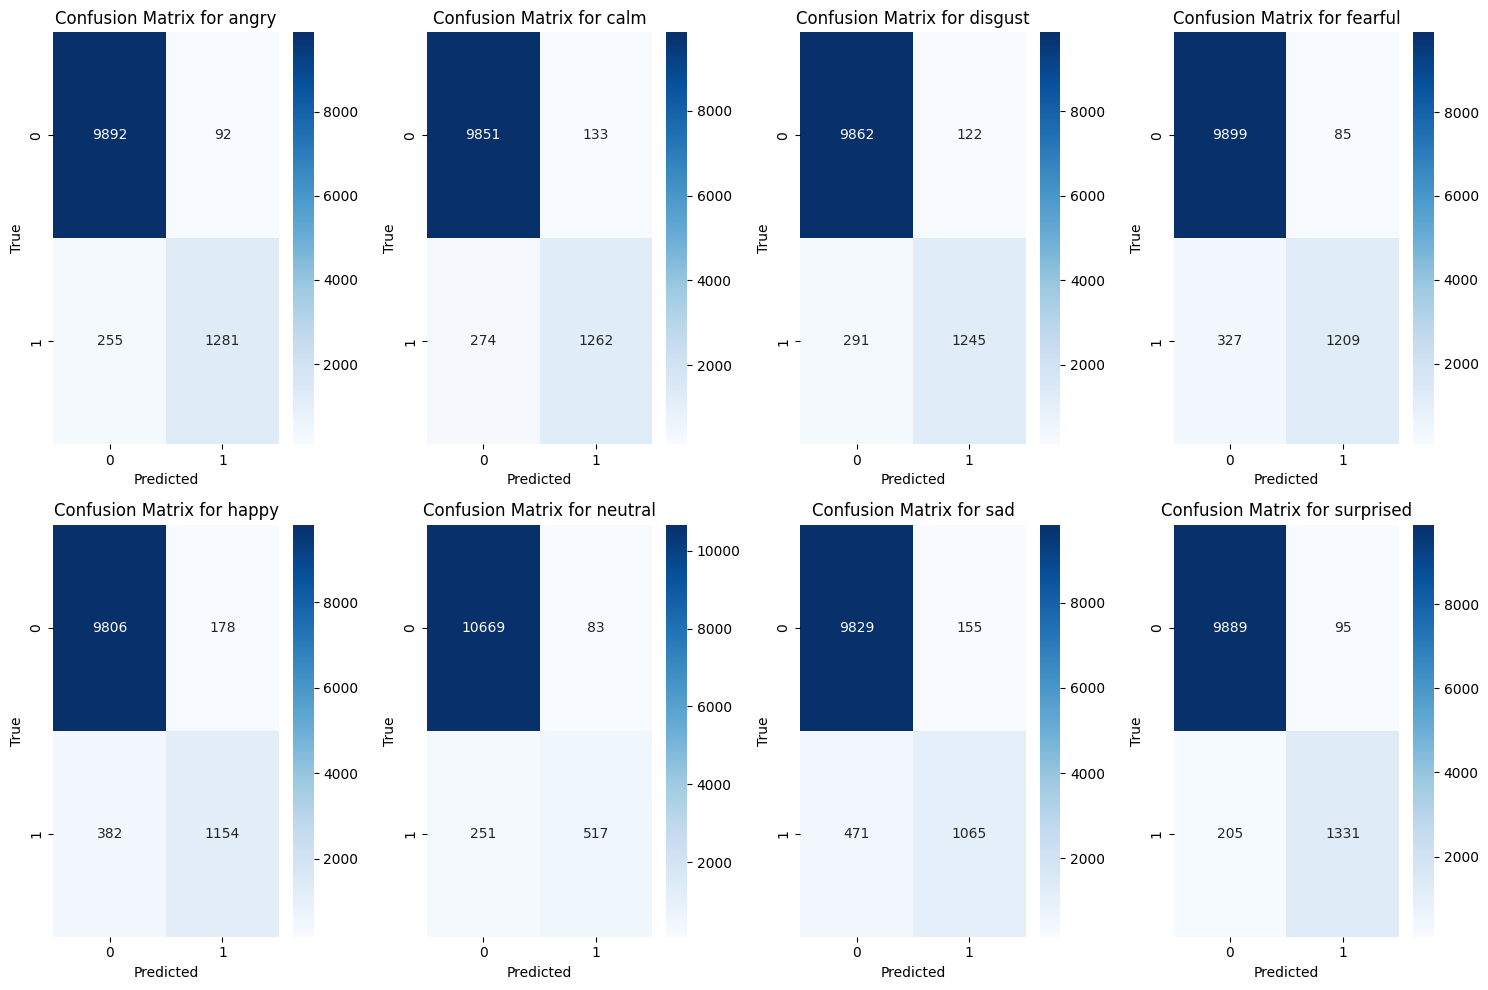

In [ ]:
# panggil fungsi plot confusion matrix dengan data agregat dari K-Fold
def plot_multi_label_confusion(y_true, y_pred, labels):
    y_pred_thresh = (y_pred > 0.5).astype(int)
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred_thresh)
    fig, axes = plt.subplots(2, int(np.ceil(len(labels) / 2)), figsize=(15, 10))
    axes = axes.flatten()

    for i, cm in enumerate(conf_matrices):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {labels[i]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

print("Menampilkan Confusion Matrix Agregat dari Semua Fold...")
plot_multi_label_confusion(all_true_labels, all_predictions, labels=mlb.classes_)

In [ ]:
import tensorflow as tf
from google.colab import files
import joblib # -> Tambahkan impor ini

print("Memulai pelatihan model final menggunakan seluruh data...")

# --- 1. Bangun Ulang Arsitektur Model Final ---
# Kode ini sama persis dengan yang ada di dalam loop K-Fold Anda
ssl_model_final = build_ssl_model(max_len=X_scaled.shape[1], emb_dim=X_scaled.shape[2])

final_model = tf.keras.Sequential([
    ssl_model_final,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_multi_encoded.shape[1], activation='sigmoid')
])

# Kompilasi model final
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 2. Latih Model pada Seluruh Dataset ---
final_model.fit(
    X_scaled, y_multi_encoded,
    epochs=40,
    batch_size=32,
    verbose=1
)

print("\nPelatihan model final selesai.")

# --- 3. Simpan Model Final ke File ---
model_filename = 'final_emotion_model.h5'
final_model.save(model_filename)
print(f"Model final telah disimpan dengan nama: {model_filename}")

# --- 4. TAMBAHAN BARU: Simpan Objek Scaler dan MLB ---
# Pastikan variabel 'scaler' dan 'mlb' tersedia dari sel-sel sebelumnya
scaler_filename = 'scaler.joblib'
mlb_filename = 'mlb.joblib'
joblib.dump(scaler, scaler_filename)
joblib.dump(mlb, mlb_filename)
print(f"Objek scaler dan mlb telah disimpan sebagai: {scaler_filename}, {mlb_filename}")


# --- 5. MODIFIKASI: Trigger Download Semua File ---
print("\nSilakan tunggu, proses download akan dimulai secara otomatis untuk ketiga file...")
files.download(model_filename)
files.download(scaler_filename)
files.download(mlb_filename)

Memulai pelatihan model final menggunakan seluruh data...
Epoch 1/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.1617 - loss: 0.4730
Epoch 2/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2923 - loss: 0.3638
Epoch 3/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3957 - loss: 0.3232
Epoch 4/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4323 - loss: 0.3048
Epoch 5/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4919 - loss: 0.2803
Epoch 6/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5516 - loss: 0.2561
Epoch 7/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5975 - loss: 0.2343
Epoch 8/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6233 - loss: 0.2183
Epoch 9/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6638 - loss: 0.2032
Epoch 10/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6954 - loss: 0.1846
Epoch 11/40
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accur


Pelatihan model final selesai.
Model final telah disimpan dengan nama: final_emotion_model.h5
Objek scaler dan mlb telah disimpan sebagai: scaler.joblib, mlb.joblib

Silakan tunggu, proses download akan dimulai secara otomatis untuk ketiga file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

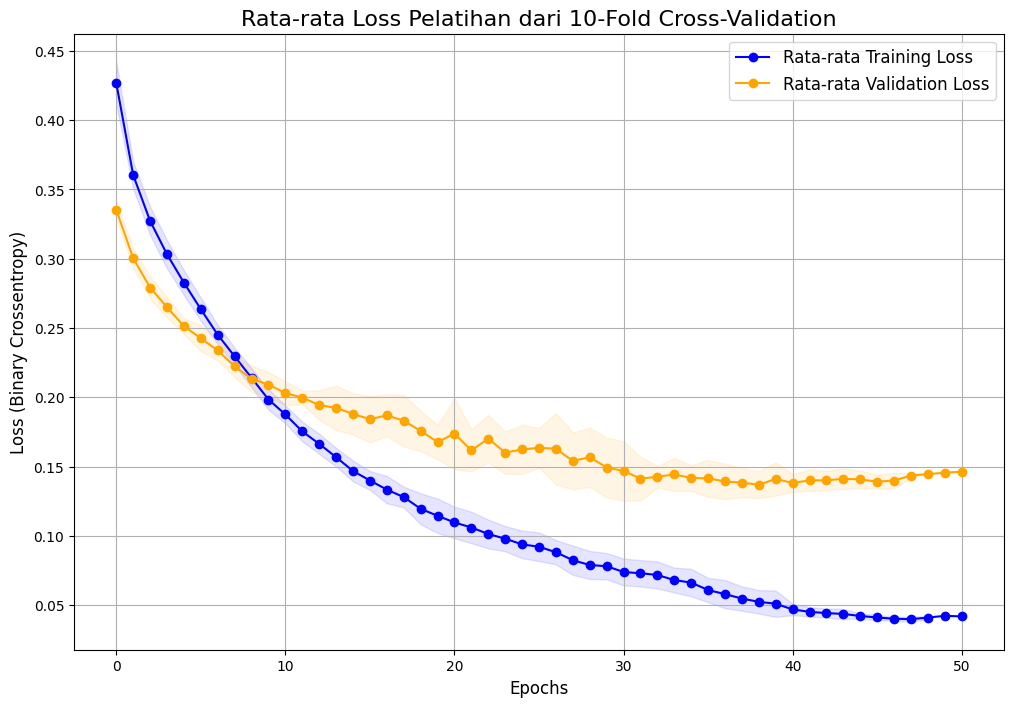

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_kfold_training_loss(histories):
    """
    Fungsi ini mengambil list dari history object hasil K-Fold,
    lalu mem-plot rata-rata training loss dan validation loss
    beserta standar deviasinya.
    """

    # Ekstrak loss dan val_loss dari setiap fold ke dalam list
    all_losses = [h.history['loss'] for h in histories]
    all_val_losses = [h.history['val_loss'] for h in histories]

    # Karena EarlyStopping, panjang setiap history bisa berbeda.
    # Kita akan membuatnya sama panjang dengan padding.
    loss_df = pd.DataFrame(all_losses).transpose()
    val_loss_df = pd.DataFrame(all_val_losses).transpose()

    # Hitung rata-rata dan standar deviasi untuk setiap epoch
    mean_loss = loss_df.mean(axis=1)
    std_loss = loss_df.std(axis=1)

    mean_val_loss = val_loss_df.mean(axis=1)
    std_val_loss = val_loss_df.std(axis=1)

    # Mulai plotting
    plt.figure(figsize=(12, 8))

    # Plot kurva rata-rata
    plt.plot(mean_loss, 'o-', color='blue', label='Rata-rata Training Loss')
    plt.plot(mean_val_loss, 'o-', color='orange', label='Rata-rata Validation Loss')

    # Buat area standar deviasi yang diarsir
    plt.fill_between(mean_loss.index, (mean_loss - std_loss), (mean_loss + std_loss),
                     color='blue', alpha=0.1)
    plt.fill_between(mean_val_loss.index, (mean_val_loss - std_val_loss), (mean_val_loss + std_val_loss),
                     color='orange', alpha=0.1)

    plt.title('Rata-rata Loss Pelatihan dari 10-Fold Cross-Validation', fontsize=16)
    plt.ylabel('Loss (Binary Crossentropy)', fontsize=12)
    plt.xlabel('Epochs', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Panggil fungsi baru dengan hasil K-Fold Anda
# Pastikan sel K-Fold sudah dijalankan dan variabel 'fold_histories' sudah ada
plot_kfold_training_loss(fold_histories)


In [ ]:
# -*- coding: utf-8 -*-
# ============== KODE PERBAIKAN UNTUK EKSPERIMEN ABLASI 1: TANPA SSL ==============
# Pastikan sel ini dijalankan SETELAH variabel X_scaled dan y_multi_encoded dibuat.

print("🧪 Memulai Eksperimen Ablasi 1: Melatih model TANPA pra-pelatihan SSL...")

# 1. Definisikan arsitektur model klasifikasi dari awal (tanpa memuat ssl_model)
def build_model_tanpa_ssl(max_len, emb_dim, num_classes):
    """Membangun model klasifikasi secara langsung tanpa bobot dari SSL."""
    inputs = tf.keras.Input(shape=(max_len, emb_dim))
    x = tf.keras.layers.Masking(mask_value=0.)(inputs)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64), return_sequences=True)(x)
    x = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(32), return_sequences=True)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# 2. Buat instance model baru
max_len = X_scaled.shape[1]
emb_dim = X_scaled.shape[2]
num_classes = y_multi_encoded.shape[1]
model_tanpa_ssl = build_model_tanpa_ssl(max_len, emb_dim, num_classes)
model_tanpa_ssl.summary()

# 3. Kompilasi model
model_tanpa_ssl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# 4. === PERBAIKAN DI SINI ===
# Buat data split khusus untuk eksperimen ini agar tidak ada NameError.
print("\nMembuat data train/test split untuk eksperimen ablasi...")
X_train_abl, X_test_abl, y_train_abl, y_test_abl = train_test_split(
    X_scaled, y_multi_encoded, test_size=0.2, random_state=42
)

# 5. Latih model
print("\nMemulai pelatihan model tanpa SSL...")
history_tanpa_ssl = model_tanpa_ssl.fit(X_train_abl, y_train_abl,
                                        epochs=100,
                                        batch_size=32,
                                        validation_data=(X_test_abl, y_test_abl), # Gunakan variabel baru
                                        callbacks=[
                                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
                                        ])

# 6. Tampilkan hasil evaluasi akhir
print("\n--- HASIL EVALUASI MODEL TANPA SSL ---")
loss, accuracy = model_tanpa_ssl.evaluate(X_test_abl, y_test_abl, verbose=0) # Gunakan variabel baru
print(f"Loss di Test Set: {loss:.4f}")
print(f"Akurasi di Test Set: {accuracy*100:.2f}%")

🧪 Memulai Eksperimen Ablasi 1: Melatih model TANPA pra-pelatihan SSL...


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 10, 1024)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 10, 1024)  │          0 │ input_layer_23[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_12          │ (None, 10, 1024)  │          0 │ input_layer_23[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_12 (Any)        │ (None, 10)        │          0 │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_24 (RNN)        │ (None, 10, 64)    │    278,784 │ masking_12[0][0], │
│                     │                   │            │ any_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_25 (RNN)        │ (None, 10, 32)    │     12,416 │ rnn_24[0][0],     │
│                     │                   │            │ any_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ rnn_25[0][0],     │
│ (GlobalAveragePool… │                   │            │ any_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 8)         │        264 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 292,520 (1.12 MB)

 Trainable params: 292,520 (1.12 MB)

 Non-trainable params: 0 (0.00 B)


Membuat data train/test split untuk eksperimen ablasi...

Memulai pelatihan model tanpa SSL...
Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1443 - loss: 0.5076 - val_accuracy: 0.2656 - val_loss: 0.3624 - learning_rate: 5.0000e-04
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2008 - loss: 0.3904 - val_accuracy: 0.3707 - val_loss: 0.3282 - learning_rate: 5.0000e-04
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.2984 - loss: 0.3522 - val_accuracy: 0.4310 - val_loss: 0.3016 - learning_rate: 5.0000e-04
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3871 - loss: 0.3232 - val_accuracy: 0.4644 - val_loss: 0.2859 - learning_rate: 5.0000e-04
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4338 - loss: 0.3043 - val_accuracy: 0.4909 - val_loss: 0.2706 - learning_rate: 5.0000e-04
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.4784 - loss: 0.2847 - val_accuracy: 0.510

In [ ]:
# 7. === TAMBAHAN BARU: HITUNG PRECISION, RECALL, F1-SCORE ===
print("\nLaporan Klasifikasi Model Tanpa SSL:")
# Dapatkan prediksi probabilitas dari model
y_pred_probs_abl = model_tanpa_ssl.predict(X_test_abl)
# Ubah probabilitas menjadi kelas biner (0 atau 1)
y_pred_binary_abl = (y_pred_probs_abl > 0.5).astype(int)
# Tampilkan laporan
print(classification_report(y_test_abl, y_pred_binary_abl, target_names=mlb.classes_))


Laporan Klasifikasi Model Tanpa SSL:
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       angry       0.91      0.79      0.85       321
        calm       0.87      0.79      0.83       306
     disgust       0.85      0.75      0.80       299
     fearful       0.86      0.77      0.81       301
       happy       0.76      0.70      0.73       298
     neutral       0.82      0.49      0.62       168
         sad       0.81      0.62      0.70       307
   surprised       0.91      0.85      0.88       304

   micro avg       0.85      0.73      0.79      2304
   macro avg       0.85      0.72      0.78      2304
weighted avg       0.85      0.73      0.79      2304
 samples avg       0.73      0.73      0.73      2304



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -*- coding: utf-8 -*-
# ============== KODE UNTUK EKSPERIMEN ABLASI 2: TANPA AUGMENTASI ==============

print("🧪 Memulai Eksperimen Ablasi 2: Melatih model TANPA augmentasi data...")

# 1. Ulangi proses pemuatan data, TAPI nonaktifkan augmentasi
X_no_aug, y_no_aug = [], []

for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            audio = preprocess_audio(file_path) #
            embedding_seq = extract_embeddings(audio) #

            label = file.split('-')[2] #
            X_no_aug.append(embedding_seq)
            y_no_aug.append(label)

            # BAGIAN AUGMENTASI DIHILANGKAN UNTUK EKSPERIMEN INI

print(f"\nTotal data TANPA augmentasi: {len(X_no_aug)} samples")

# 2. Lakukan preprocessing ulang untuk data tanpa augmentasi
X_padded_no_aug = pad_sequences(X_no_aug, padding='post', dtype='float32') #

num_samples_no_aug, max_len_no_aug, emb_dim_no_aug = X_padded_no_aug.shape
X_reshaped_no_aug = X_padded_no_aug.reshape(-1, emb_dim_no_aug)

scaler_no_aug = StandardScaler()
X_scaled_no_aug = scaler_no_aug.fit_transform(X_reshaped_no_aug) #
X_scaled_no_aug = X_scaled_no_aug.reshape(num_samples_no_aug, max_len_no_aug, emb_dim_no_aug)

multi_labels_no_aug = [label_to_multilabel(lab) for lab in y_no_aug] #
mlb_no_aug = MultiLabelBinarizer()
y_multi_encoded_no_aug = mlb_no_aug.fit_transform(multi_labels_no_aug) #

print("Shape data tanpa augmentasi setelah di-preprocess:", X_scaled_no_aug.shape)


# 3. Jalankan kembali pipeline SSL + Fine-tuning pada data baru ini
print("\n--- TAHAP 1: PRA-PELATIHAN SSL (TANPA AUGMENTASI) ---")
X_ssl_input_no_aug, X_ssl_target_no_aug = mask_embeddings(X_scaled_no_aug) #

ssl_model_no_aug = build_ssl_model(max_len_no_aug, emb_dim_no_aug) #
ssl_model_no_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae') #
ssl_model_no_aug.fit(X_ssl_input_no_aug, X_ssl_target_no_aug,
                     epochs=50,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]) #

print("\n--- TAHAP 2: FINE-TUNING (TANPA AUGMENTASI) ---")
fine_tune_model_no_aug = tf.keras.Sequential([
    ssl_model_no_aug,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_multi_encoded_no_aug.shape[1], activation='sigmoid')
]) #

fine_tune_model_no_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                               loss='binary_crossentropy',
                               metrics=['accuracy']) #

# --> Perhatikan, blok ini sudah memiliki train_test_split sendiri, jadi tidak akan error.
X_train_no_aug, X_test_no_aug, y_train_no_aug, y_test_no_aug = train_test_split(
    X_scaled_no_aug, y_multi_encoded_no_aug, test_size=0.2, random_state=42
) #

fine_tune_model_no_aug.fit(X_train_no_aug, y_train_no_aug,
                           epochs=100,
                           batch_size=32,
                           validation_data=(X_test_no_aug, y_test_no_aug),
                           callbacks=[
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
                           ]) #

# 4. Tampilkan hasil evaluasi akhir
print("\n--- HASIL EVALUASI MODEL TANPA AUGMENTASI ---")
loss, accuracy = fine_tune_model_no_aug.evaluate(X_test_no_aug, y_test_no_aug, verbose=0)
print(f"Loss di Test Set: {loss:.4f}")
print(f"Akurasi di Test Set: {accuracy*100:.2f}%")

🧪 Memulai Eksperimen Ablasi 2: Melatih model TANPA augmentasi data...

Total data TANPA augmentasi: 2880 samples
Shape data tanpa augmentasi setelah di-preprocess: (2880, 10, 1024)

--- TAHAP 1: PRA-PELATIHAN SSL (TANPA AUGMENTASI) ---
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.6051 - val_loss: 0.4492
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4453 - val_loss: 0.3876
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3736 - val_loss: 0.3027
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2911 - val_loss: 0.2348
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2290 - val_loss: 0.1891
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1917 - val_loss: 0.1717
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1783 - val_loss: 0.1648
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1725 - val_loss: 0.1611
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1688 - val_loss: 0.1594

In [ ]:
# 5. === TAMBAHAN BARU: HITUNG PRECISION, RECALL, F1-SCORE ===
print("\nLaporan Klasifikasi Model Tanpa Augmentasi:")
# Dapatkan prediksi probabilitas dari model
y_pred_probs_no_aug = fine_tune_model_no_aug.predict(X_test_no_aug)
# Ubah probabilitas menjadi kelas biner (0 atau 1)
y_pred_binary_no_aug = (y_pred_probs_no_aug > 0.5).astype(int)
# Tampilkan laporan
print(classification_report(y_test_no_aug, y_pred_binary_no_aug, target_names=mlb_no_aug.classes_))


Laporan Klasifikasi Model Tanpa Augmentasi:
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

       angry       0.95      0.89      0.92        84
        calm       0.91      0.94      0.93        67
     disgust       1.00      0.81      0.89        88
     fearful       0.88      0.82      0.85        68
       happy       0.97      0.73      0.83        92
     neutral       1.00      0.75      0.86        36
         sad       0.85      0.77      0.81        73
   surprised       0.94      0.94      0.94        68

   micro avg       0.93      0.83      0.88       576
   macro avg       0.94      0.83      0.88       576
weighted avg       0.94      0.83      0.88       576
 samples avg       0.83      0.83      0.83       576



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -*- coding: utf-8 -*-
# ============== KODE UNTUK EKSPERIMEN TUNING LEARNING RATE ==============

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

# Pastikan ssl_model dari pelatihan utama sudah tersedia
# Pastikan X_scaled dan y_multi_encoded juga sudah tersedia

def run_finetuning_with_new_lr(learning_rate, ssl_model_base, X_data, y_data):
    """Fungsi untuk menjalankan eksperimen fine-tuning dengan learning rate berbeda."""

    print(f"\n============================================================")
    print(f"🧪 Memulai Eksperimen: Learning Rate = {learning_rate}")
    print(f"============================================================")

    # 1. Bangun ulang arsitektur fine-tuning
    # Menggunakan ssl_model yang sudah dilatih dari model utama Anda
    model_ft = tf.keras.Sequential([
        ssl_model_base,
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_data.shape[1], activation='sigmoid')
    ])

    # 2. Kompilasi dengan learning rate yang baru
    model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

    # 3. Buat data split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    # 4. Latih model
    model_ft.fit(X_train, y_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 verbose=0, # Dibuat 0 agar output tidak terlalu ramai
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                 ])

    # 5. Evaluasi dan tampilkan hasil
    print(f"--- HASIL UNTUK LEARNING RATE {learning_rate} ---")
    loss, accuracy = model_ft.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {loss:.4f}, Akurasi: {accuracy*100:.2f}%")

    y_pred_probs = model_ft.predict(X_test)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)
    print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_))


# --- Jalankan eksperimen untuk beberapa nilai learning rate ---
# Anda bisa menambahkan nilai lain jika perlu

# Catatan: Pastikan variabel 'ssl_model' adalah model SSL yang sudah dilatih dari notebook utama Anda
run_finetuning_with_new_lr(learning_rate=0.001, ssl_model_base=ssl_model, X_data=X_scaled, y_data=y_multi_encoded)
run_finetuning_with_new_lr(learning_rate=0.0001, ssl_model_base=ssl_model, X_data=X_scaled, y_data=y_multi_encoded)


🧪 Memulai Eksperimen: Learning Rate = 0.001
--- HASIL UNTUK LEARNING RATE 0.001 ---
Loss: 0.1919, Akurasi: 71.66%
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

       angry       0.82      0.80      0.81       321
        calm       0.85      0.68      0.76       306
     disgust       0.85      0.72      0.78       299
     fearful       0.88      0.63      0.74       301
       happy       0.77      0.39      0.51       298
     neutral       0.65      0.44      0.53       168
         sad       0.85      0.34      0.49       307
   surprised       0.90      0.80      0.85       304

   micro avg       0.84      0.61      0.71      2304
   macro avg       0.82      0.60      0.68      2304
weighted avg       0.83      0.61      0.69      2304
 samples avg       0.61      0.61      0.61      2304


🧪 Memulai Eksperimen: Learning Rate = 0.0001


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- HASIL UNTUK LEARNING RATE 0.0001 ---
Loss: 0.1590, Akurasi: 77.52%
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

       angry       0.91      0.77      0.83       321
        calm       0.87      0.77      0.82       306
     disgust       0.83      0.78      0.80       299
     fearful       0.91      0.69      0.78       301
       happy       0.82      0.58      0.68       298
     neutral       0.84      0.42      0.56       168
         sad       0.80      0.63      0.70       307
   surprised       0.89      0.84      0.86       304

   micro avg       0.86      0.70      0.77      2304
   macro avg       0.86      0.68      0.76      2304
weighted avg       0.86      0.70      0.77      2304
 samples avg       0.70      0.70      0.70      2304



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -*- coding: utf-8 -*-
# ============== KODE UNTUK EKSPERIMEN TUNING MASK RATE ==============

def run_full_pipeline_with_new_mask_rate(mask_rate, X_data, y_data, mlb_classes):
    """Menjalankan seluruh pipeline (SSL + Fine-tuning) dengan mask_rate berbeda."""

    print(f"\n============================================================")
    print(f"🧪 Memulai Eksperimen: Mask Rate = {mask_rate*100:.0f}%")
    print(f"============================================================")

    # --- TAHAP 1: PRA-PELATIHAN SSL ---
    print("--- Tahap 1: SSL Pre-training ---")
    X_ssl_input, X_ssl_target = mask_embeddings(X_data, mask_rate=mask_rate)

    # Ambil dimensi dari data
    max_len, emb_dim = X_data.shape[1], X_data.shape[2]

    ssl_model_exp = build_ssl_model(max_len, emb_dim)
    ssl_model_exp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
    ssl_model_exp.fit(X_ssl_input, X_ssl_target,
                      epochs=50, batch_size=32, validation_split=0.2, verbose=0,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # --- TAHAP 2: FINE-TUNING ---
    print("--- Tahap 2: Fine-tuning ---")
    model_ft_exp = tf.keras.Sequential([
        ssl_model_exp,
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_data.shape[1], activation='sigmoid')
    ])

    model_ft_exp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    model_ft_exp.fit(X_train, y_train,
                     epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0,
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    # --- EVALUASI ---
    print(f"--- HASIL UNTUK MASK RATE {mask_rate*100:.0f}% ---")
    loss, accuracy = model_ft_exp.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {loss:.4f}, Akurasi: {accuracy*100:.2f}%")

    y_pred_probs = model_ft_exp.predict(X_test)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)
    print(classification_report(y_test, y_pred_binary, target_names=mlb_classes))

# --- Jalankan eksperimen untuk beberapa nilai mask rate ---
run_full_pipeline_with_new_mask_rate(mask_rate=0.05, X_data=X_scaled, y_data=y_multi_encoded, mlb_classes=mlb.classes_)
run_full_pipeline_with_new_mask_rate(mask_rate=0.20, X_data=X_scaled, y_data=y_multi_encoded, mlb_classes=mlb.classes_)


🧪 Memulai Eksperimen: Mask Rate = 5%
--- Tahap 1: SSL Pre-training ---
--- Tahap 2: Fine-tuning ---
--- HASIL UNTUK MASK RATE 5% ---
Loss: 0.1916, Akurasi: 74.83%
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

       angry       0.89      0.77      0.82       321
        calm       0.79      0.81      0.80       306
     disgust       0.78      0.77      0.77       299
     fearful       0.84      0.70      0.77       301
       happy       0.83      0.57      0.67       298
     neutral       0.80      0.24      0.37       168
         sad       0.84      0.42      0.56       307
   surprised       0.91      0.80      0.85       304

   micro avg       0.84      0.66      0.74      2304
   macro avg       0.84      0.63      0.70      2304
weighted avg       0.84      0.66      0.72      2304
 samples avg       0.66      0.66      0.66      2304


🧪 Memulai Eksperimen: Mask Rate = 20%
--- Tahap 1: SSL Pre-training ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Tahap 2: Fine-tuning ---
--- HASIL UNTUK MASK RATE 20% ---
Loss: 0.1902, Akurasi: 70.88%
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

       angry       0.92      0.68      0.78       321
        calm       0.86      0.74      0.79       306
     disgust       0.80      0.76      0.78       299
     fearful       0.84      0.60      0.70       301
       happy       0.81      0.48      0.60       298
     neutral       0.71      0.31      0.43       168
         sad       0.86      0.36      0.51       307
   surprised       0.83      0.79      0.81       304

   micro avg       0.84      0.61      0.70      2304
   macro avg       0.83      0.59      0.68      2304
weighted avg       0.84      0.61      0.69      2304
 samples avg       0.61      0.61      0.61      2304



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!nvidia-smi

Tue Jul 22 14:17:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             29W /   70W |    1274MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----